<a href="https://colab.research.google.com/github/lohkesh-m/Portfolio_Optimizier_Lohkesh/blob/main/Portfolio_Optimizer_Convex_Optimization_Mean_variance.ipynb" target="_parent"><img src="https://colab.research.google.com/assets/colab-badge.svg" alt="Open In Colab"/></a>

In [1]:
pip install yfinance

Looking in indexes: https://pypi.org/simple, https://us-python.pkg.dev/colab-wheels/public/simple/
     |████████████████████████████████| 62 kB 336 kB/s 
  Attempting uninstall: requests
    Found existing installation: requests 2.23.0
    Uninstalling requests-2.23.0:
      Successfully uninstalled requests-2.23.0


In [2]:
import yfinance as yf

import cvxpy as cp

import numpy as np
import pandas as pd
import pandas_datareader.data as pdr


from pandas_datareader import data as pdr
import datetime

import matplotlib.pyplot as plt
%matplotlib inline 
import seaborn as sns

# Input Section

In [3]:
Tickers_total=['TSM','ADBE','COST','KKR','CSCO','UNH','VRTX']
start_date = '01-01-2016'
end_date = '27-06-2022'

global riskFreeRate
riskFreeRate=0.02

global Tickers_Sectorwise
Tickers_Sectorwise={'Tech':['TSM','ADBE','CSCO'],'Healthcare':['UNH','VRTX'],'Financials':['KKR'],'RealEstate':[],'ConsumerStaples':['COST'],'ConsumerDiscretionary':[],'Energy':[],'Industrials':[]}

Sector_Constraints={'Tech':[0.1,0.3],'Healthcare':[0.05,0.15],'Financials':[0.05,0.15],'RealEstate':[0.05,0.15],'ConsumerStaples':[0.05,0.15],'ConsumerDiscretionary':[0.05,0.15],'Energy':[0.05,0.15],'Industrials':[0.05,0.15]}

# Functions

### Minor Functions

In [4]:
def convertPricetoReturn(HistoricalData_price,tickers):
  logPrice=np.log(HistoricalData_price)
  HistoricalData_returns=logPrice[1:,:]-logPrice[:-1,:]
  return pd.DataFrame(HistoricalData_returns,columns=tickers)

In [5]:
def Get_Portfolio_Tickers_Sectorwise_and_SectorwiseCount(Portfolio_Tickers):
  Portfolio_Tickers_Sectorwise={}
  SectorwiseCount={}
  for i in Portfolio_Tickers:
    for j in Tickers_Sectorwise:
      if j not in SectorwiseCount.keys():
        SectorwiseCount.update({j:0})
      if i in Tickers_Sectorwise[j]:
        Portfolio_Tickers_Sectorwise.update({i:j})
        SectorwiseCount[j]+=1
      

  return [Portfolio_Tickers_Sectorwise,SectorwiseCount]

### Getting Historical Data

In [6]:
def getHistoricalData_AdjClose(Ticker_List,Start,End):
  data=[]
  daily_prices_list=[]
  data_final= pd.DataFrame()
  yf.pdr_override()
  
  if isinstance(Start,str):
    Start = datetime.datetime.strptime(Start, '%d-%m-%Y')
  if isinstance(End,str):
    End = datetime.datetime.strptime(End, '%d-%m-%Y')
  for i,k in enumerate(Ticker_List):
    try:
      data_input=(pdr.get_data_yahoo(k, data_source='yahoo', start=Start, end=End)['Adj Close'])
      data_final[k]=data_input
    except Exception:
      print('Not found',k)
      pass
  
  return data_final

### Mathematical Optimization

In [7]:
def getConstraintsMatrix(Portfolio_Tickers,Sector_Constraints={}):
  
  A=np.zeros(shape=(len(Sector_Constraints.keys()),len(Portfolio_Tickers)))
  if len(Sector_Constraints)==0:
    return
  
  Portfolio_Tickers_Sectorwise=Get_Portfolio_Tickers_Sectorwise_and_SectorwiseCount(Portfolio_Tickers)[0]

  for i in range(0,len(Sector_Constraints.keys())):
    for j in range(0,len(Portfolio_Tickers_Sectorwise)):
      if list(Sector_Constraints.keys())[i]==Portfolio_Tickers_Sectorwise[Portfolio_Tickers[j]]:
        A[i,j] =1
  
  MinWeights=np.array(list(Sector_Constraints.values()))[:,0].reshape(len(Sector_Constraints.keys()),1)
  MaxWeights=np.array(list(Sector_Constraints.values()))[:,1].reshape(len(Sector_Constraints.keys()),1)

  for i in range(0,len(Sector_Constraints.keys())):
    if A[i,:].any()==False:
      MinWeights[i]=0
      MaxWeights[i]=0
    
    if sum(MaxWeights)<1.1:
      MaxWeights=MaxWeights*1.1/(sum(MaxWeights))

  return [A,MinWeights,MaxWeights]

In [8]:
def Optimize_risk(Portfolio_Tickers,mu,sigma,Sector_Constraints):
  # Defining initial variables
  x = cp.Variable((mu.shape[1], 1))
  
  # Budget and weights constraints
  constraints = [
            x <= 1,
            x >= 0]

  #Sector Constraints
  if len(Sector_Constraints.keys())!=0:
    [A,MinWeights,MaxWeights]=getConstraintsMatrix(Portfolio_Tickers,Sector_Constraints)

    print(np.shape(A@x),np.shape(MaxWeights))
    constraints = [ cp.sum(x) == 1,
                   x <= 1,
                   x >= 0,
                   A@x >= MinWeights,
                   A@x <= MaxWeights]

  risk = cp.quad_form(x, sigma)
  objective = cp.Minimize(risk)

  weights = pd.DataFrame([])
  # Solving the problem with several solvers
  prob = cp.Problem(objective, constraints)

  #solvers = ['ECOS', 'SCS']
  prob.solve(solver='ECOS')
  # Showing Optimal Weights

  weights = pd.DataFrame(x.value, index=Portfolio_Tickers, columns=['Weights'])
  return weights
                

In [9]:
def Optimize_Returns(Portfolio_Tickers,mu,sigma):
  # Defining initial variables
  x = cp.Variable((mu.shape[1], 1))
  
  # Budget and weights constraints
  constraints = [cp.sum(x) == 1,
                x <= 1,
                x >= 0]
                

In [10]:
def Optimize_Sharpe(Portfolio_Tickers,expected_returns,sigma,Sector_Constraints):

  expected_Returns_transformed= expected_returns-np.ones(expected_returns.shape)*riskFreeRate
  muT=expected_Returns_transformed.reshape(1,-1)

  y = cp.Variable((muT.shape[1], 1))
  risk=cp.quad_form(y,sigma)

  transformed_returns=muT @ y
  constraints=[ muT @ y ==1,
              y>=0]

  if len(Sector_Constraints.keys())!=0:
    [A,MinWeights,MaxWeights]=getConstraintsMatrix(Portfolio_Tickers,Sector_Constraints)

    Amin=np.zeros(shape=np.shape(A))
    Amax=np.zeros(shape=np.shape(A))
    
    for i in range(0,len(MaxWeights)):
      Amin[i,:]=A[i,:]-np.ones(shape=np.shape(Amin[i,:]))*MinWeights[i]
      Amax[i,:]=A[i,:]-np.ones(shape=np.shape(Amax[i,:]))*MaxWeights[i]
    
    constraints = [ muT @ y ==1,
                  y >= 0,
                  Amin@y >= 0,
                  Amax@y <= 0]

  objective = cp.Minimize(risk)

  weights = pd.DataFrame([])
  # Solving the problem with several solvers
  prob = cp.Problem(objective, constraints)
  solvers = ['ECOS', 'SCS']
  #solvers = ['ECOS', 'SCS']
  prob.solve(solver='ECOS')
  # Storing Optimal Weights
  weights = pd.DataFrame(y.value/sum(y.value), index=Portfolio_Tickers, columns=['Weights'])
  return weights

In [11]:
def Port_Optimizer_CvxOptimization(Portfolio_Tickers,expected_returns,covariance_matrix,Sector_Constraints={},ObjectiveFunction='Sharpe',returnType='Dataframe'):
  # Defining initial inputs
  expected_returns=252*expected_returns
  mu = expected_returns.reshape(1,-1)
  sigma = 252*covariance_matrix
  
  if ObjectiveFunction=='Risk':
    Weights=Optimize_risk(Portfolio_Tickers,mu,sigma,Sector_Constraints)
  elif ObjectiveFunction=='Sharpe':
    Weights=Optimize_Sharpe(Portfolio_Tickers,expected_returns,sigma,Sector_Constraints)

  if returnType=='Array':
    return np.array(Weights['Weights'])

  if returnType=='List':
    return np.array(Weights).tolist()

  display(Weights)

  Optimized_Returns= expected_returns @ np.array(Weights)

  Optimized_Volatility=(np.dot(np.array(Weights).T,np.dot(sigma,np.array(Weights))))**0.5

  Optimized_Sharpe=(Optimized_Returns-riskFreeRate)/Optimized_Volatility
  
  return [Weights,Optimized_Returns,Optimized_Volatility,Optimized_Sharpe]


### Backtest Function

In [12]:
def backtest_Optimizer(Portfolio_tickers,Sector_Constraints,ObjectiveFunction='Sharpe',Benchmark="SP500",Backtest_duration=10,Number_of_Rebalance=10):
  BenchmarkDict={"SP500":[["^GSPC"],[1]],"NASDAQ100":[["^NDX"],[1]],"60/40":[0,[0.6,0.4]]}
  if Benchmark not in BenchmarkDict.keys():
    print(f"Invalid Benchmark. List of Available Benchmarks:{BenchmarkDict.keys()}")

  Start=datetime.datetime(datetime.datetime.now().year-Backtest_duration,1,1)
  End=datetime.datetime.now()

  Benchmark_ticker=BenchmarkDict[Benchmark][0]
  Benchmark_weights=np.array(BenchmarkDict[Benchmark][1])
  BenchmarkReturns=[0]

  Backtest_data=getHistoricalData_AdjClose(Portfolio_tickers,Start,End)
  print("--------------------Loaded Backtest Data---------------------------")
  BenchmarkData=getHistoricalData_AdjClose(Benchmark_ticker,Start,End)
  print("--------------------Loaded Benchmark Data---------------------------")

  Rebalance_period=int(len(Backtest_data)/Number_of_Rebalance)

  Portfolio_value=[1]
  Portfolio_returns_list=[0]
  Portfolio_weights_historical=[]

  start=np.array(Backtest_data.iloc[0])
  b_start=np.array(BenchmarkData.iloc[0])
  
  for i in range(0,len(Backtest_data)-1):

    if i%Rebalance_period==0:

      Rebalance_data=getHistoricalData_AdjClose(Portfolio_Tickers,pd.Timestamp(year=Backtest_data.index[i].year-3,month=1,day=1),Backtest_data.index[i])
      Rebalance_data=convertPricetoReturn(Rebalance_data.to_numpy(copy=True),Rebalance_data.columns)

      Expected_Returns=np.array(Rebalance_data.mean())
      Covariance_Matrix=np.array(Rebalance_data.cov())

      print(f"--------------------Rebalance {int(i/Rebalance_period)} of {int(len(Backtest_data)/Rebalance_period)}---------------------------")

      Portfolio_weights=Port_Optimizer_CvxOptimization(Portfolio_tickers,Expected_Returns,Covariance_Matrix,Sector_Constraints,ObjectiveFunction,returnType='List')

      Portfolio_weights_historical.append(Portfolio_weights)
    
    if Backtest_data.index[i+1].month!=Backtest_data.index[i].month:

      temp=np.array(Backtest_data.iloc[i])
      Stock_Returns=np.log(temp)-np.log(start)
      start=temp
      [Portfolio_returns]=np.dot(np.array(Portfolio_weights).T,Stock_Returns).tolist()

      Portfolio_returns_list.append(Portfolio_returns)

      b_temp=np.array(BenchmarkData.iloc[i])
      BenchmarkReturns.append(np.dot(Benchmark_weights,np.log(b_temp)-np.log(b_start)))
      b_start=b_temp

  
  return [Portfolio_returns_list,Portfolio_weights_historical,BenchmarkReturns]



## Runtime Code


### Historical Price Data and returns

In [13]:
HistoricalPriceData=getHistoricalData_AdjClose(Tickers_total,start_date,end_date)

[*********************100%***********************]  1 of 1 completed
[*********************100%***********************]  1 of 1 completed
[*********************100%***********************]  1 of 1 completed
[*********************100%***********************]  1 of 1 completed
[*********************100%***********************]  1 of 1 completed
[*********************100%***********************]  1 of 1 completed
[*********************100%***********************]  1 of 1 completed


In [14]:
HistoricalPriceData.head()


,TSM,ADBE,COST,KKR,CSCO,UNH,VRTX
Date,,,,,,,
2016-01-04,18.029854,91.970001,140.122879,13.396483,21.543215,105.460785,122.889999
2016-01-05,17.915586,92.339996,140.465408,13.116327,21.445326,105.659973,123.449997
2016-01-06,17.417707,91.019997,139.165558,12.853152,21.216927,104.582382,122.230003
2016-01-07,17.221815,89.110001,135.977356,12.301333,20.727493,101.503487,114.959999
2016-01-08,16.985117,87.849998,133.597214,12.021179,20.213593,99.755768,110.709999


In [15]:
HistoricalPriceData.tail()

,TSM,ADBE,COST,KKR,CSCO,UNH,VRTX
Date,,,,,,,
2022-06-17,85.000000,360.790009,445.920319,45.056404,43.002953,452.059998,263.089996
2022-06-21,86.949997,362.989990,462.311981,46.243149,43.746262,480.320007,270.170013
2022-06-22,84.910004,365.329987,459.167419,45.694653,43.181347,489.679993,272.309998
2022-06-23,84.120003,376.640015,474.181519,46.263096,42.547058,499.809998,283.500000
2022-06-24,85.919998,387.720001,483.535370,48.437130,43.706619,495.640015,292.549988


In [16]:
HistoricalReturnsData=convertPricetoReturn(HistoricalPriceData.to_numpy(copy=True),HistoricalPriceData.columns)

In [17]:
HistoricalReturnsData.mean()

TSM     0.000958
ADBE    0.000883
COST    0.000760
KKR     0.000789
CSCO    0.000434
UNH     0.000949
VRTX    0.000532
dtype: float64

### Variance-Covariance Matrix

In [18]:
HistoricalReturnsData.cov()

,TSM,ADBE,COST,KKR,CSCO,UNH,VRTX
TSM,0.000376,0.000215,0.000096,0.000207,0.000151,0.000124,0.000136
ADBE,0.000215,0.000434,0.000143,0.000244,0.000187,0.000156,0.000203
COST,0.000096,0.000143,0.000198,0.000118,0.000110,0.000099,0.000089
KKR,0.000207,0.000244,0.000118,0.000512,0.000182,0.000175,0.000169
CSCO,0.000151,0.000187,0.000110,0.000182,0.000288,0.000132,0.000149
UNH,0.000124,0.000156,0.000099,0.000175,0.000132,0.000291,0.000143
VRTX,0.000136,0.000203,0.000089,0.000169,0.000149,0.000143,0.000518


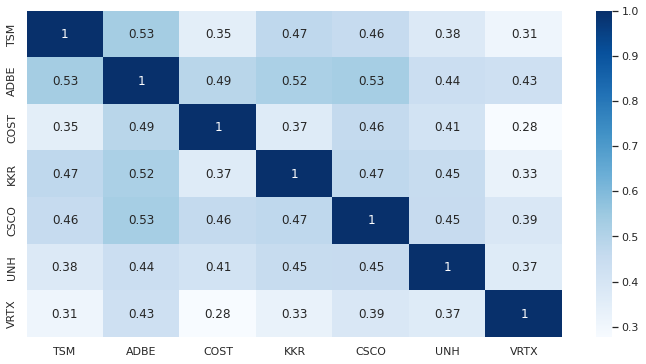

In [19]:
sns.set()
plt.figure(figsize=(12,6))
sns.heatmap(HistoricalReturnsData.corr(), annot = True, cmap = 'Blues')

### Running the Simulation

In [20]:
Portfolio_Tickers=HistoricalPriceData.columns
[Portfolio_Tickers_Sectorwise,sectorwiseCount]=Get_Portfolio_Tickers_Sectorwise_and_SectorwiseCount(Portfolio_Tickers)
print(Portfolio_Tickers_Sectorwise)
print(sectorwiseCount)


{'TSM': 'Tech', 'ADBE': 'Tech', 'COST': 'ConsumerStaples', 'KKR': 'Financials', 'CSCO': 'Tech', 'UNH': 'Healthcare', 'VRTX': 'Healthcare'}
{'Tech': 3, 'Healthcare': 2, 'Financials': 1, 'RealEstate': 0, 'ConsumerStaples': 1, 'ConsumerDiscretionary': 0, 'Energy': 0, 'Industrials': 0}


In [21]:
Historical_Expected_Returns=np.array(HistoricalReturnsData[Portfolio_Tickers].mean())
Historical_Covariance_Matrix=np.array(HistoricalReturnsData[Portfolio_Tickers].cov())

In [22]:
print(Historical_Expected_Returns*1000)

[0.95790655 0.88271226 0.7598802  0.78851192 0.43401144 0.94939307
 0.53211405]


In [23]:
print(Historical_Expected_Returns.reshape(1,-1)*1000)

[[0.95790655 0.88271226 0.7598802  0.78851192 0.43401144 0.94939307
  0.53211405]]


In [24]:
[Weights,[Returns],[[Volatility]],[[Sharpe]]]=Port_Optimizer_CvxOptimization(Portfolio_Tickers,Historical_Expected_Returns,Historical_Covariance_Matrix,Sector_Constraints)

,Weights
TSM,3.573571e-01
ADBE,8.264287e-02
COST,2.200000e-01
KKR,1.200000e-01
CSCO,3.465442e-11
UNH,2.200000e-01
VRTX,1.827332e-11


In [25]:
print(sum(Weights['Weights']))

0.9999999999999999


In [26]:
np.set_printoptions(4)
print(f"Optimized Sharpe Ratio Value: {Sharpe}")
print(f"Optimal Weights: ")
display(Weights) 

print(f"Optimized Return: {Returns}")
print(f"Optimized Volatility: {Volatility}")

Optimized Sharpe Ratio Value: 0.9342314344046895
Optimal Weights: 


,Weights
TSM,3.573571e-01
ADBE,8.264287e-02
COST,2.200000e-01
KKR,1.200000e-01
CSCO,3.465442e-11
UNH,2.200000e-01
VRTX,1.827332e-11


Optimized Return: 0.2232533924700879
Optimized Volatility: 0.2175621425108704


### Backtest

In [27]:
[Portfolio_returns_list,Portfolio_weights_historical,BenchmarkReturns]=backtest_Optimizer(Portfolio_Tickers,Sector_Constraints,ObjectiveFunction='Sharpe',Benchmark="SP500")

[*********************100%***********************]  1 of 1 completed
[*********************100%***********************]  1 of 1 completed
[*********************100%***********************]  1 of 1 completed
[*********************100%***********************]  1 of 1 completed
[*********************100%***********************]  1 of 1 completed
[*********************100%***********************]  1 of 1 completed
[*********************100%***********************]  1 of 1 completed
--------------------Loaded Backtest Data---------------------------
[*********************100%***********************]  1 of 1 completed
--------------------Loaded Benchmark Data---------------------------
[*********************100%***********************]  1 of 1 completed
[*********************100%***********************]  1 of 1 completed
[*********************100%***********************]  1 of 1 completed
[*********************100%***********************]  1 of 1 completed
[*********************100%*********

In [28]:
print(Portfolio_returns_list)
Backtest_Mean_returns=np.mean(np.array(Portfolio_returns_list))
print(Backtest_Mean_returns)
Benchmark_Mean_returns=np.mean(np.array(BenchmarkReturns))
print(Benchmark_Mean_returns)

[0, 0.027519119572209913, 0.04583685420877477, 0.051328033271625925, -0.014441993838299368, -0.08161194258106798, 0.050647988395806344, -0.0013697751547723086, 0.043597457069659375, 0.049769622205918025, 0.00023903151414189587, 0.03361136350983946, 0.013489804079385026, 0.043807141258880515, 0.02392556813917361, 0.015312844583652748, 0.06936594680954092, -0.007385760356979876, 0.0076442236548193545, 0.026455357071091482, -0.031711270566042844, 0.029853524400315662, 0.0392937297788139, 0.03433907194598808, -0.009475341847026909, -0.03462851883291311, 0.0895065872791521, -0.026454163861177306, -0.03854352296903706, 0.03663644766985753, 0.07032828388528962, -0.02151275771619686, 0.04035083721319374, -0.01018339314394644, 0.03697469775022515, 0.04885998113669422, 0.0038107172726419276, -0.0023120722788924244, 0.07734352484953189, -0.01210153843012033, -0.006647465585831025, 0.027766948775560997, -0.009871529563863998, 0.026447033823847808, -0.07388376744922934, 0.005214196349442407, 0.0623

1.9169699431199834 1.173787024933258
128


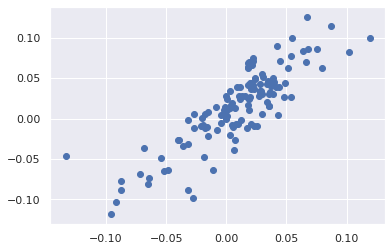

In [29]:
print(sum(Portfolio_returns_list),sum(BenchmarkReturns))
print(len(BenchmarkReturns))

plt.scatter(BenchmarkReturns,Portfolio_returns_list)

In [30]:
Portfolio_std=np.std(np.array(Portfolio_returns_list))
Benchmark_std=np.std(np.array(BenchmarkReturns))
print(Portfolio_std)
print(Benchmark_std)


0.0465783525238657
0.03967225875219636


In [31]:
Portfolio_sharpe=(Backtest_Mean_returns-(riskFreeRate)/12)/Portfolio_std
print((12**0.5)*Portfolio_sharpe)
Benchmark_sharpe=(Benchmark_Mean_returns-(riskFreeRate)/12)/Portfolio_std
print((12**0.5)*Benchmark_sharpe)

0.9898593599197164
0.5580498041297024


In [36]:
A=np.vstack([BenchmarkReturns,np.ones(len(BenchmarkReturns))]).T
m, c = np.linalg.lstsq(A, Portfolio_returns_list, rcond=None)[0]
print(f"Alpha={12*c},Beta={m} (Annualized Alpha)")

Alpha=0.06959878373590728,Beta=1.000678054581857 (Annualized Alpha)


In [33]:
A=Portfolio_weights_historical

In [34]:
Portfolio_Tickers

Index(['TSM', 'ADBE', 'COST', 'KKR', 'CSCO', 'UNH', 'VRTX'], dtype='object')

In [35]:
np.array(A).reshape((11,7))


array([[4.4000e-01, 1.2553e-11, 2.2000e-01, 1.2000e-01, 7.1361e-12,
        2.2000e-01, 5.0648e-12],
       [3.6765e-01, 1.7324e-11, 2.2000e-01, 1.9235e-01, 1.1468e-11,
        2.2000e-01, 1.1509e-11],
       [7.4962e-03, 4.3250e-01, 2.2000e-01, 1.2000e-01, 4.5669e-11,
        1.8979e-01, 3.0212e-02],
       [1.3155e-01, 2.8027e-01, 2.2000e-01, 1.2000e-01, 2.8182e-02,
        1.8852e-01, 3.1482e-02],
       [4.5718e-02, 3.9428e-01, 2.2000e-01, 1.2000e-01, 2.2927e-09,
        2.2000e-01, 1.6045e-11],
       [2.1887e-01, 2.2113e-01, 2.2000e-01, 1.2000e-01, 1.1873e-09,
        2.2000e-01, 4.7073e-11],
       [3.2615e-11, 4.4000e-01, 2.2000e-01, 1.2000e-01, 1.0036e-11,
        2.2000e-01, 1.7043e-12],
       [9.6020e-10, 2.3510e-01, 2.2000e-01, 1.2000e-01, 2.0490e-01,
        2.2000e-01, 1.4803e-11],
       [5.6777e-10, 4.4000e-01, 2.2000e-01, 1.2000e-01, 7.7261e-11,
        9.6222e-11, 2.2000e-01],
       [2.5616e-01, 1.8384e-01, 2.2000e-01, 2.2000e-01, 1.1011e-11,
        1.2000e-01, 2.3